# 罗伯·瑞克超额现金流选股法则

- 罗伯·瑞克，华尔街著名的资本大鳄，从事证券行业近 50 年。本篇介绍的罗伯·瑞克超 额现金流选股法则是由其在接受股票书籍作者采访时，给投资者的投资建议所提炼而成。
- 罗伯·瑞克超额现金流选股法则从三个角度对投资标的进行考察，一是估值水平，二是分 红水平，三是财务状况。从这三个角度，瑞克共提出 5 个选股标准，均是瑞克价值投资理 念的重要体现。而其中，罗伯·瑞克尤其重视股价和现金流的关系，倾向于现金流相对市 值更加充足的公司。
- 罗伯·瑞克超额现金流选股法则中，5 条选股非常明确，各项标准基本均可量化。因此测试过程没有加入我们的主观，失真程度非常小。

**导入pyfolio库如果报错则重新运行一下即可**

In [130]:
import tushare as ts
from jqdata import *

import json
import numpy as np
import pandas as pd
 
from functools import reduce
from tqdm import tqdm_notebook
from dateutil.parser import parse

from alphalens.utils import print_table
from pyfolio.plotting import (plot_drawdown_periods,
                              show_worst_drawdown_periods)

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.style.use('seaborn')

# 数据获取函数准备

In [2]:
class TuShare:
    """tushare服务接口自动重试封装类，能够在接口超时情况下自动等待1秒然后再次发起请求，
    无限次重试下去，直到返回结果或者达到最大重试次数。
    """

    def __init__(self, token, logger=None, max_retry=0):
        """构造函数，token：tushare的token；logger：日志对象，可以不传；
        max_retry：最大重试次数，默认为0意为无限重试，建议用10以上100以内。"""
        self.token = token
        if not logger:
            logger = logging.getLogger('TuShare')
            # CRITICAL > ERROR > WARNING > INFO > DEBUG > NOTSET
            logger.setLevel(logging.DEBUG)
            formatter = logging.Formatter(
                '%(asctime)s %(name)s %(pathname)s:%(lineno)d %(funcName)s %(levelname)s %(message)s'
            )
            handler = logging.StreamHandler()
            handler.setFormatter(formatter)
            handler.setLevel(logging.DEBUG)
            logger.addHandler(handler)
        self.logger = logger
        self.max_retry = max_retry
        ts.set_token(token)
        self.pro = ts.pro_api()

    def __getattr__(self, name):

        def wrapper(*args, **kwargs):
            i = 0
            while True:
                try:
                    if name == 'pro_bar':
                        m = getattr(ts, name, None)
                    else:
                        m = getattr(self.pro, name, None)
                    if m is None:
                        self.logger.error('Attribute %s does not exist.', name)
                        return None
                    else:
                        return m(*args, **kwargs)
                except (Exception):
                    if self.max_retry > 0 and i >= self.max_retry:
                        raise
                    self.logger.exception(
                        'TuShare exec %s failed, args:%s, kwargs:%s, try again.',
                        name, args, kwargs)
                    time.sleep(1)
                i += 1

        return wrapper
    
setting = json.load(open('../../config.json'))
pro = TuShare(setting['token'], max_retry=10)  # 初始化ts

In [3]:
def get_crossdata(watch_date: str, rpt_date: str) -> pd.DataFrame:
    
    # 获取股票池
    stocks = get_stocks_pool(watch_date)
    
    # 行业过滤
    ## 过滤银行股
    ser = get_stocks_ind(stocks,watch_date,'sw_l1','name')
    stocks = ser[ser!="银行I"].index.tolist()
    
    BALANCE_FIELD = ('lt_borr', 'st_borr', 'total_assets')
    
    # 资产负债表数据
    balance_df = pd.concat([get_near_fundamental(
        pro.balancesheet_vip, col, watch_date, rpt_date) for col in BALANCE_FIELD], sort=True, axis=1)

    # 财务指标
    indicator_ser = get_near_fundamental(
        pro.fina_indicator_vip, 'fcff', watch_date, rpt_date)

    # 股息率
    dividendyield = pro.daily_basic(
        trade_date=transform2tsdate(watch_date), fields='ts_code,dv_ttm,pe_ttm,pb')

    dividendyield['ts_code'] = dividendyield['ts_code'].replace(
        {'SH': 'XSHG', 'SZ': 'XSHE'}, regex=True)

    dividendyield.set_index('ts_code', inplace=True)

    close = get_price(stocks, end_date=watch_date,
                      count=1, fields='close', panel=False)
    close = close[['code', 'close']].set_index('code')

    df = pd.concat([close, balance_df, indicator_ser,
                    dividendyield], sort=True, axis=1)
    
    df = df.reindex(stocks)

    return df


def get_stocks_pool(watch_date: str) -> list:
    '''
    获取全A股票
    -----------
        过滤条件1:上市大于6个月（180日）
               2:过滤st
               3:当日未交易或停牌
    '''

    # 获取全A数据
    stocks = get_all_securities(types='stock', date=watch_date)

    # 过滤上市不足180日
    ipolistday = (parse(watch_date).date() - stocks['start_date']).dt.days
    stocks = stocks[ipolistday > 180].index.tolist()

    # 过滤ST
    st_ser = get_extras('is_st', stocks, end_date=watch_date, count=1).iloc[-1]
    stocks = st_ser[st_ser == False].index.tolist()

    # 过滤当日未交易
    pause = get_price(stocks, end_date=watch_date, count=1,
                      fields='paused', panel=False)
    stocks = pause.query('paused==0')['code'].values.tolist()

    return stocks


def get_near_fundamental(func, col: str, watch_date: str, rpt_date: str) -> pd.Series:
    '''
    获取watch_date日的rpt_date期财务数据
    '''

    rptdate = transform2tsdate(rpt_date)
    watchdate = parse(watch_date)

    df = func(period=rptdate, fields=f'ts_code,ann_date,end_date,{col}')
    df = df.dropna(subset=['ann_date'])  # 丢弃na即未发布财报数据股票

    # 代码重复可能有数据更新 保留更新后的财务数据
    df = df.drop_duplicates(subset=['ts_code'], keep='last')

    df['ann_date'] = pd.to_datetime(df['ann_date'])
    # ts_code转为聚宽代码
    df['ts_code'] = df['ts_code'].replace(
        {'SH': 'XSHG', 'SZ': 'XSHE'}, regex=True)

    max_day = df['ann_date'].max()
    min_day = df['ann_date'].min()

    pivot_df = pd.pivot_table(
        df, index='ann_date', columns='ts_code', values=col).fillna(method='ffill')

    # watchdate在实际财报公布日期范围内的处理 缺失部分为未公布的 不会使用上一期的补齐
    if min_day <= watchdate <= max_day:

        ser = pivot_df.loc[:watch_date].iloc[-1]
        ser.name = col
        return ser

    # 如果watch_date小于实际财报公布日期 则自动获取最近一期即上一期数据
    elif watchdate < min_day:

        rptdate = pd.date_range(end=rptdate, periods=2, freq='Q')[
            0].strftime('%Y-%m-%d')
        return get_near_fundamental(func, col, watch_date, rptdate)

    else:

        ser = pivot_df.iloc[-1]
        ser.name = col
        return ser


def transform2tsdate(date: str) -> str:
    '''转为ts所需日期'''

    if isinstance(date, datetime.date):
        return date.strftime('%Y%m%d')

    return date.replace('-', '')


def get_stocks_ind(stocks: list, watch_date: str, name: str, method: str = 'code') -> pd.Series:
    '''
    获取股票列表行业
    ------------
        name:行业名称 sw_l1...等
        method:code返回行业代码，name返回行业名称
    '''
    # 获取行业
    industry_dic = get_industry(stocks, date=watch_date)

    industry_ser = pd.Series({k: v.get(name, {f'industry_{method}': np.nan})[
                             f'industry_{method}'] for k, v in industry_dic.items()})

    return industry_ser


def OffsetRptdateN(start: str, end: str, N: int = 60) -> dict:
    '''
    获取报告日日后N日的时间节点
    ------------
        return (滞后的交易日,财报日)
    '''
    periods = [i.strftime('%Y-%m-%d')
               for i in pd.date_range(start=start, end=end, freq='Q')]

    offset_days = [OffsetDate(i, N).strftime('%Y-%m-%d') for i in periods]

    rpts = list(filter(lambda x: x <= end, offset_days))

    return dict(zip(rpts, periods))


def OffsetDate(end_date: str, count: int) -> datetime.date:
    '''
    end_date:为基准日期
    count:为正则后推，负为前推
    -----------
    return datetime.date
    '''

    trade_date = get_trade_days(end_date=end_date, count=1)[0]

    if count > 0:
        # 将end_date转为交易日

        trade_cal = get_all_trade_days().tolist()

        trade_idx = trade_cal.index(trade_date)

        return trade_cal[trade_idx + count]

    elif count < 0:

        return get_trade_days(end_date=trade_date, count=abs(count))[0]

    else:

        raise ValueError('别闹！')


罗伯·瑞克提供给《Stock picking-The 11 Best Tactics for beating The Market》作者的投资方法集中体现了罗伯·瑞克的价值投资理念，这套选股方法即 是本篇介绍的罗伯·瑞克超额现金流选股法则。该投资策略从三个角度对股票提出要 求，其一、股票具备合理的估值；其二、股票具备一定的分红收益；其三、公司的财 务状况要求健康。 以这三个角度出发选择五个指标，分别是市净率、市盈率、股息收益率、市现率、借款总额占总资本比例，共同构建了选股准则，形成了罗伯·瑞克超额现金流选股法 则。这五条准则非常清晰明确，均为可直接量化实现的准则。每条准则具有明确的量 化描述和判断条件，除个别部分需对中国市场调整外，我们的回测将严格按照这五条准则复制，不存在需主观判断而不能量化的准则。

## 罗伯·瑞克超额现金流选股法则的通用版本

1. 市净率低于 1.5 
2. 股利收益率高于市场平均值 
3. 市盈率低于市场平均值
4. 借款总额占总资本比例低于 33%
5. 股价/超额现金流量比低于 7.5

## 罗伯·瑞克超额现金流选股法则初始版本投资分析

归纳罗伯·瑞克超额现金流选股法则初始版本，可以大致总结策略衡量的三个方面： 
1. 用市盈率、市净率、股价/超额现金流来衡量股票的估值，要求买入的投资标的足够“便宜”，具有合理的估值。其中罗伯·瑞克格外强调股价/超额现金流的作用。这里的`超额现金流可认为是自由现金流`
2. 用总借款/总资本来衡量公司的偿债能力和财务结构，保证买入的投资标的具备足够强大的资产负债表。 
3. 用股息收益率来衡量股票的分红水平，保证价值投资者能够获得一定的分红收益。

## 罗伯·瑞克超额现金流选股法则的中国化改造

结合中国投资市场的实际情况之后，在研究和回测中对部分原始标准进行调整： 

+ 1改为：市净率低于 3
+ 5改为：股价现金流量比低于全市场平均值的80%

**回测具体逻辑**

回测区间：2010-01-01至2020-09-30
调仓时点：每个报告日的60日后进行调仓

股票池：
1. 全A成份股,过滤银行股；
2. 剔除当日无法交易/停牌股；
3. 上市不足6个月的次新股；
4. 剔除ST/*ST股

筛选标准：
1. 市净率低于3
2. 股利收益率高于市场平均值 
3. 市盈率低于市场平均值
4. 借款总额占总资本比例低于33%
5. 股价/超额现金流量比低于市场平均的80%

In [4]:
def get_preprocessing_date(start: str, end: str) -> pd.DataFrame:

    periods = OffsetRptdateN(start, end)  # 获取时间节点

    df_dic = {}  # 储存中间变量

    for trade, rptdate in tqdm_notebook(periods.items(), desc='数据获取中'):

        df_dic[trade] = get_crossdata(trade, rptdate)

    df = pd.concat(df_dic)
    df = df.fillna(value={'lt_borr': 0, 'st_borr': 0})

    # 计算借款/总资产
    df = df.assign(borr2total=lambda x: (
        x.lt_borr + x.st_borr) / x.total_assets)

    # 计算收盘为/企业自由现金流
    df = df.assign(c_fcff=lambda x: x.close / x.fcff)
    df.index.names = ['date', 'code']
    
    return df

def get_criteria_df(df:pd.DataFrame)->pd.DataFrame:
    '''
    条件选股
    '''
    market_mean_div = df['dv_ttm'].mean()
    market_mean_pe = df['pe_ttm'].mean()
    market_fcff_mean = df['c_fcff'].mean() * 0.8

    COND = ('pb < 3 and '
            'dv_ttm > @market_mean_div and '
            'pe_ttm < @market_mean_pe and '
            'borr2total < 0.33 and '
            'c_fcff < @market_fcff_mean')

    return df.query(COND)

In [18]:
# 数据准备
data = get_preprocessing_date('2008-12-31','2020-09-30')
# 数据储存
data.to_csv('../../Data/master_13.csv')

In [5]:
# 测试时间段
START = '2010-01-01'
END = '2020-09-30'

In [106]:
# 数据读取
df = pd.read_csv('../../Data/master_13.csv',index_col=[0,1],parse_dates=[0])
df1 = df1.loc[parse(START):].copy()

# 数据结构
df1.head()

close      ...             c_fcff
date       code                    ...                   
2010-04-02 000001.XSHE   7.58      ...      -3.546132e-10
           000002.XSHE   7.04      ...      -4.997170e-09
           000005.XSHE   6.07      ...                NaN
           000006.XSHE   3.68      ...      -2.152676e-09
           000009.XSHE   5.34      ...       1.689540e-08

[5 rows x 10 columns]

In [23]:
# 符合条件的股票

criteria_df = df1.groupby(level='date', group_keys=False).apply(get_criteria_df)

可以看到在指数上涨时符合条件的股票较少，而震荡和下跌时符合条件的股票在增多

*红色(左轴)为每期符合条件的个股数量,灰色(右轴)为沪深上证综指。*

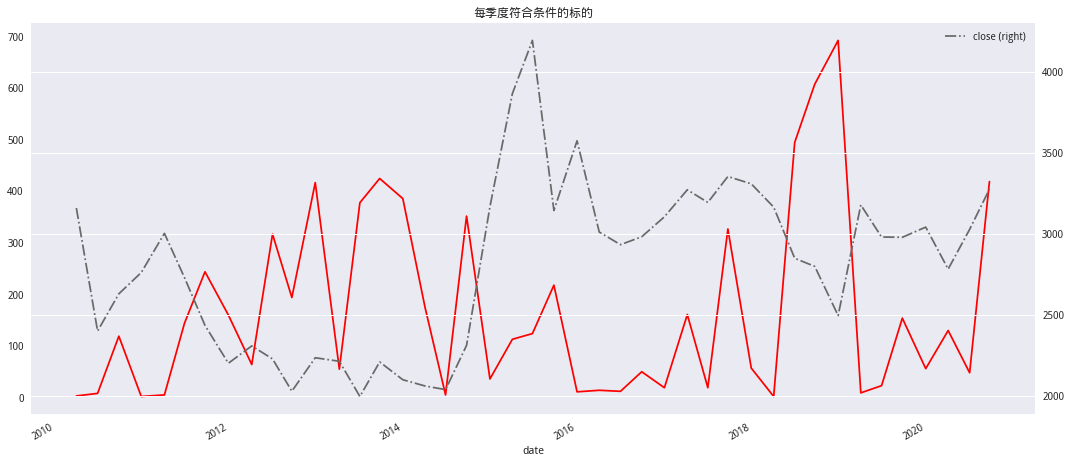

In [25]:
plt.rcParams['font.family'] = 'serif'

# 选用上证综指为基准
benchmark = get_price('000001.XSHG',START,END,fields='close')

line = criteria_df.groupby(level='date').size().plot(figsize=(18, 8),
                                                 title='每季度符合条件的标的', color='r')

benchmark.reindex(criteria_df.index.levels[0]).plot(
    y='close', secondary_y=True, ax=line, color='Dimgray', ls='-.')

In [191]:
# 储存条件
criteria_df.to_csv('../../criteria_df.csv')

# 条件选股回测

通过上述对研报中的策略进行回测发现，每期入选的个数差异很大，最少为0最多时可能有200多个,所以这里我们对上述`条件选股`方式进行改进，通过将数据当作因子处理的方式以期获得更为稳定的收益。

In [147]:
def algorithm_show(backtestid: str):

    # 获取回测收益情况
    gt = get_backtest(backtestid)
    algorithm_returns = pd.DataFrame(gt.get_results())
    algorithm_returns['time'] = pd.to_datetime(algorithm_returns['time'])
    algorithm_returns.set_index('time', inplace=True)

    plt.rcParams['font.family'] = 'serif'
    # 净值
    algorithm_returns.plot(figsize=(18, 6), title='回测收益',color=[
                    'LightGrey','LightCoral'])
    # 回撤标记
    plt.figure(figsize=(18,6))
    ret_ser = (algorithm_returns['returns']+1).pct_change()
    plot_drawdown_periods(ret_ser,5)
    plt.title('前5大回撤标记')
    
    # 回撤分析
    show_worst_drawdown_periods(ret_ser)
    # 风险收益
    print_table(pd.Series(gt.get_risk()).iloc[1:].to_frame('回测情况'))

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,61.30,2015-06-15,2018-10-18,NaT,NaN
1,53.42,2010-04-28,2012-12-03,2014-12-12,1208
2,9.63,2015-05-04,2015-05-07,2015-05-21,14
3,6.56,2010-04-02,2010-04-13,2010-04-16,11
4,5.91,2010-04-16,2010-04-19,2010-04-22,5


,回测情况
algorithm_return,0.323109
algorithm_volatility,0.27435
alpha,0.00280403
annual_algo_return,0.0271391
annual_bm_return,0.0241154
avg_excess_return,5.86294e-05
avg_position_days,250.379
avg_trade_return,0.0680783
benchmark_return,0.282945
benchmark_volatility,0.231394


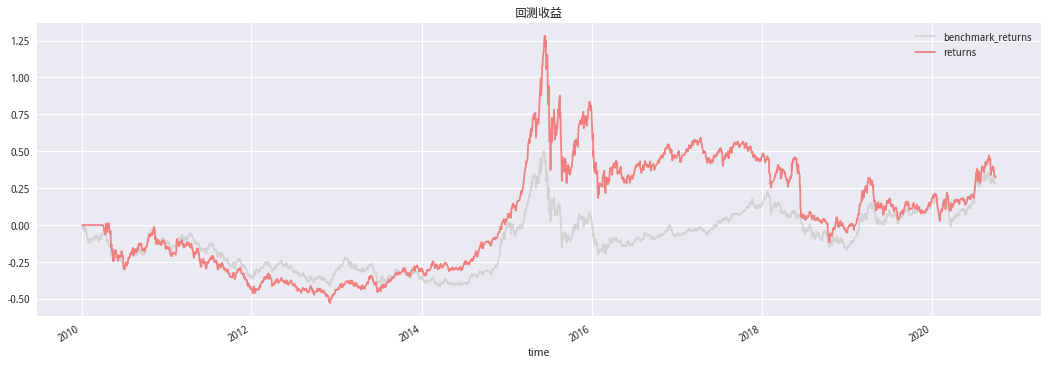

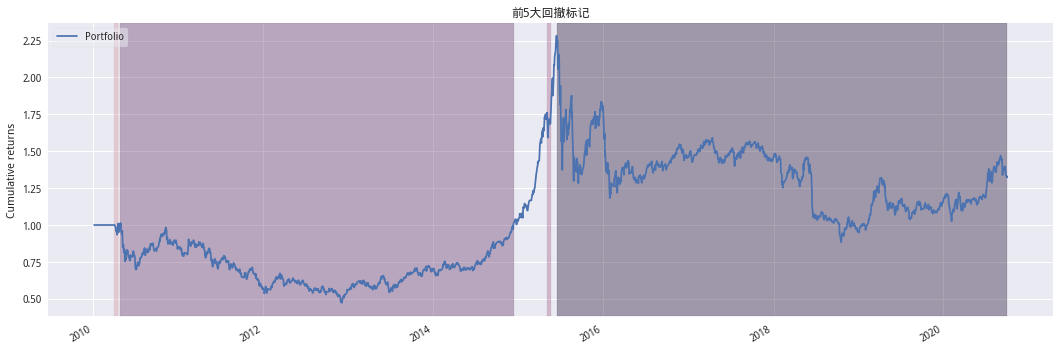

In [148]:
algorithm_show('3dd99dee66c39b1c2ba0e6b72734325d')

# 因子化

由于条件选股的一些固有问题所以这里我直接简单粗暴的打分分组处理以期提升收益(未进行缺失值处理及标准化、中性化处理)

In [8]:
# 拷贝副本
df2 = df1[['c_fcff','pe_ttm','pb','dv_ttm','borr2total']].copy()

In [45]:
def get_next_ret(factor: pd.DataFrame, keep_last_term: bool = False, last_term_next_date: str = None) -> pd.Series:
    '''
    keep_last_term:是否保留最后一期数据
    last_term_next_date:如果keep_last_term=True,则此参数为计算最后一期下期收益时的截止时间,必须时交易日
    '''

    securities = factor.index.levels[1].tolist()  # 股票代码
    periods = [i.strftime('%Y-%m-%d') for i in factor.index.levels[0]]  # 日期

    if keep_last_term:
        end = last_term_next_date
        periods = periods + [end]

        if not end:
            raise ValueError('如果keep_last_term=True,则必须有last_term_next_date参数')

    close = pd.concat([get_price(securities, end_date=i, count=1, fields='close', panel=False)
                       for i in periods])

    close = pd.pivot_table(close, index='time', columns='code', values='close')
    ret = close.pct_change().shift(-1)
    ret = ret.iloc[:-1]
    
    factors = factor.copy()
    factors['next_ret'] = ret.stack()
    
    return factors

def score_indicators(factors: pd.DataFrame, ind_direction: dict) -> pd.DataFrame:
    '''
    根据因子等权打分
    -------------
        factors:pd.DataFram MutliIndex:leve0-date,level1-code
        ind_direction:根据什么方式排序
    '''

    params_dic = {'descending': False, 'ascending': True}

    df_list = [factors.groupby(level='date')[k].transform(lambda x:x.rank(
        ascending=params_dic[v])) for k, v in ind_direction.items()]

    factors_ = factors.copy()
    factors_['score'] = reduce(lambda x, y: x.fillna(0)+y.fillna(0), df_list)
    return factors_


def add_group(factors: pd.DataFrame, ind_name: str = None, group_num: int = 5, direction: str = 'ascending') -> pd.DataFrame:
    '''
    分组打分
    -------------
        factors:pd.DataFram MutliIndex:leve0-date,level1-code
        ind_name:需要分组的因子名,默认根据score列排序
        group_num:分几组
        direction:根据什么方式排序
    '''

    params_dic = {'descending': False, 'ascending': True}

    factors = factors.copy()

    if not ind_name:

        ind_name = 'score'

    def _group(ser) -> pd.Series:

        ranks = ser.rank(ascending=params_dic[direction])

        label = ['G'+str(i) for i in range(1, group_num + 1)]

        category = pd.cut(ranks, bins=group_num, labels=label)
        category.name = 'group'
        return category

    factors['group'] = factors.groupby(level='date')[ind_name].apply(_group)
    
    return factors

In [46]:
# 获取下期收益率
df2 = get_next_ret(df2,True,'2020-10-30')

In [25]:
# 打分 根据逻辑调整升/降序排列
ind_direction = {'pb': 'descending',
                 'pe_ttm': 'descending',
                 'dv_ttm': 'ascending',
                 'borr2total': 'descending',
                 'c_fcff': 'descending'}

# 打分
df_score = score_indicators(df2, ind_direction)

# 分组
group_data = add_group(df_score)

# 收益率
ret = pd.pivot_table(group_data.reset_index(), index='date',
                     columns='group', values='next_ret')
# 净值
nav = np.exp(np.log1p(ret).cumsum())

感觉分组单调性还行

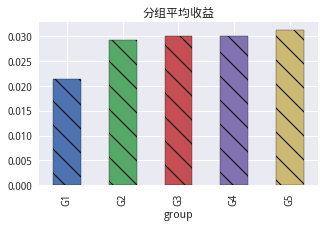

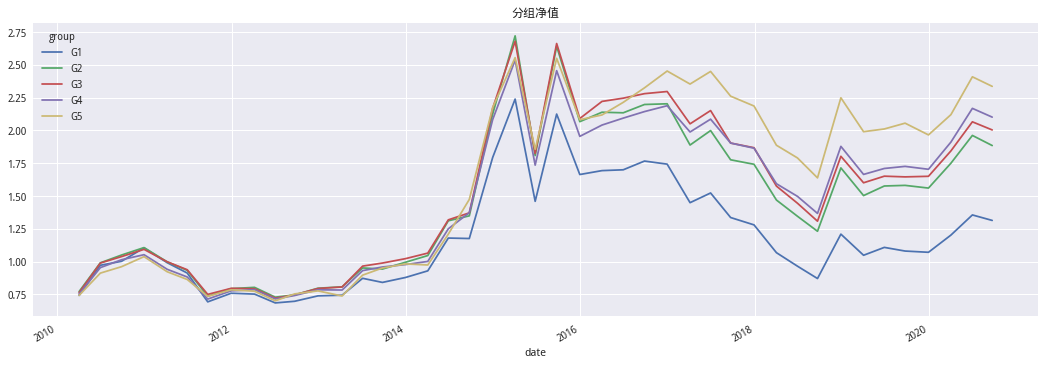

In [75]:
plt.rcParams['font.family'] = 'serif'
ret.mean().plot.bar(hatch='\\', ec='black', figsize=(5, 3), title='分组平均收益')

nav.plot(figsize=(18, 6), title='分组净值')

简单的利用回测模块回测：

- 时间范围:2010-01-01至2020-09-30
- 持有股票：每期选第5组的前30支股票

In [89]:
# 获取第5组 得分前30的股票
result_df = group_data.query('group=="G5"').groupby(level='date')[
    'score'].nlargest(30).reset_index(level=0, drop=True)

result_df = result_df.to_frame('score')

# 储存
result_df.to_csv('../../result_df.csv')

可以看到收益由之前的32.31%变为113.99%，回撤也有所降低

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,52.18,2015-06-11,2018-10-18,NaT,NaN
1,35.06,2010-11-08,2012-12-03,2014-02-17,856
2,28.13,2010-04-02,2010-07-01,2010-10-25,147
3,9.51,2014-02-19,2014-06-19,2014-07-31,117
4,7.99,2015-05-04,2015-05-07,2015-05-20,13


,回测情况
algorithm_return,1.13987
algorithm_volatility,0.255478
alpha,0.0506183
annual_algo_return,0.0754689
annual_bm_return,0.0241154
avg_excess_return,0.000229353
avg_position_days,179.318
avg_trade_return,0.0505151
benchmark_return,0.282945
benchmark_volatility,0.231394


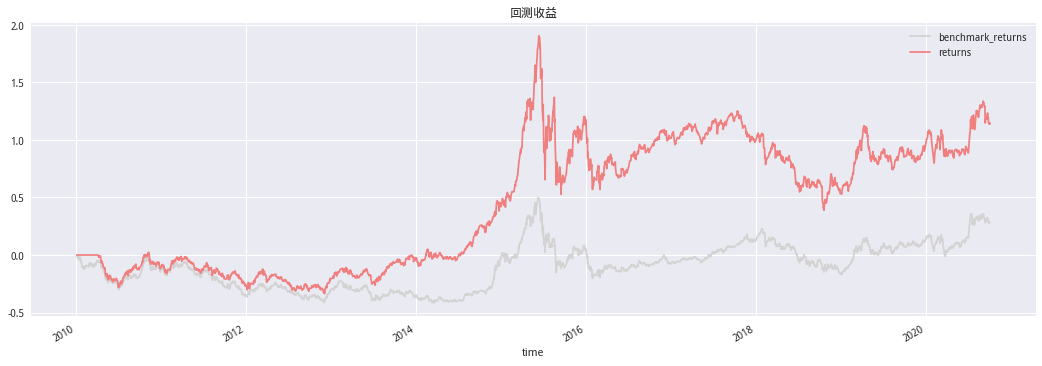

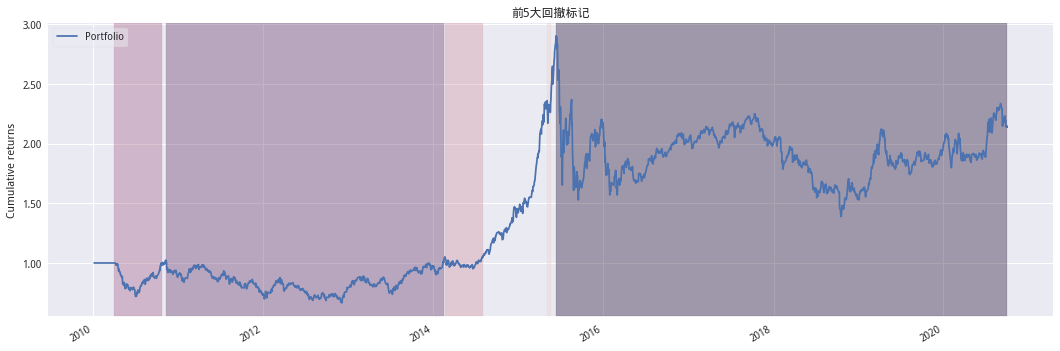

In [149]:
algorithm_show('1df4815574813a11f5e663216205fe19')

## HP滤波

HP滤波那篇研报有提到过说移动平均效果与HP滤波效果相当，这里我们使用窗口期为4期对指标移动平均后计算对应的因子；回撤有一定改善,但收益也有所减少

In [184]:
df3 = df.copy()

df3.loc[:, ['lt_borr', 'st_borr','total_assets','fcff']] = df3[[
    'lt_borr', 'st_borr','total_assets','fcff']].rolling(4).mean()
df3 = df3.assign(c_fcff=lambda x: (x.lt_borr + x.st_borr) / x.total_assets)
df3 = df3.loc[parse(START):].copy()

In [185]:
# 获取下期收益率
df4 = get_next_ret(df3,True,'2020-10-30')

In [186]:
# 打分 根据逻辑调整升/降序排列
ind_direction = {'pb': 'descending',
                 'pe_ttm': 'descending',
                 'dv_ttm': 'ascending',
                 'borr2total': 'descending',
                 'c_fcff': 'descending'}

# 打分
df_score1 = score_indicators(df4, ind_direction)

# 分组
group_data1 = add_group(df_score1)

# 收益率
ret1 = pd.pivot_table(group_data1.reset_index(), index='date',
                     columns='group', values='next_ret')
# 净值
nav1 = np.exp(np.log1p(ret1).cumsum())

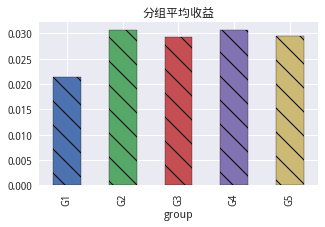

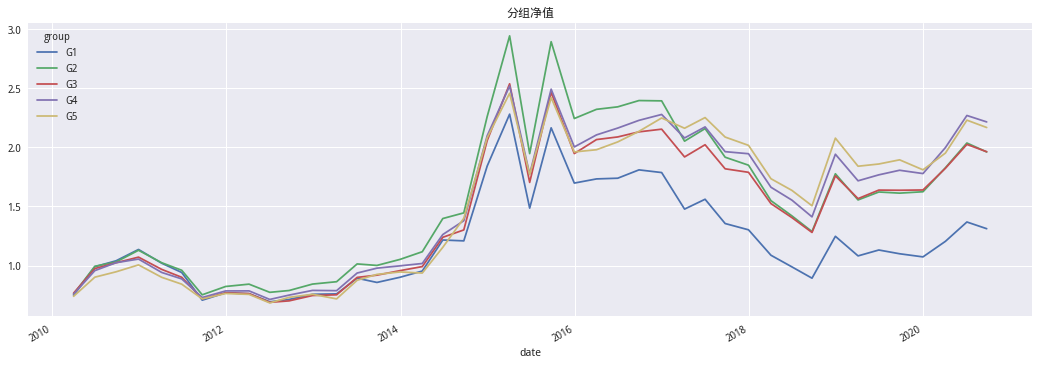

In [187]:
plt.rcParams['font.family'] = 'serif'
ret1.mean().plot.bar(hatch='\\', ec='black', figsize=(5, 3), title='分组平均收益')

nav1.plot(figsize=(18, 6), title='分组净值')

In [188]:
# 获取第5组 得分前30的股票
result_df1 = group_data1.query('group=="G5"').groupby(level='date')[
    'score'].nlargest(30).reset_index(level=0, drop=True)

result_df1 = result_df1.to_frame('score')

# 储存
result_df1.to_csv('../../result_df1.csv')

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,48.33,2015-06-12,2018-10-18,NaT,NaN
1,39.01,2010-04-02,2012-12-03,2014-09-29,1172
2,8.98,2015-04-27,2015-05-07,2015-05-21,19
3,6.39,2015-05-27,2015-05-28,2015-06-02,5
4,5.82,2015-01-06,2015-01-19,2015-01-22,13


,回测情况
algorithm_return,0.897589
algorithm_volatility,0.240791
alpha,0.0381866
annual_algo_return,0.0631804
annual_bm_return,0.0241154
avg_excess_return,0.000170565
avg_position_days,286.719
avg_trade_return,0.0561581
benchmark_return,0.282945
benchmark_volatility,0.231394


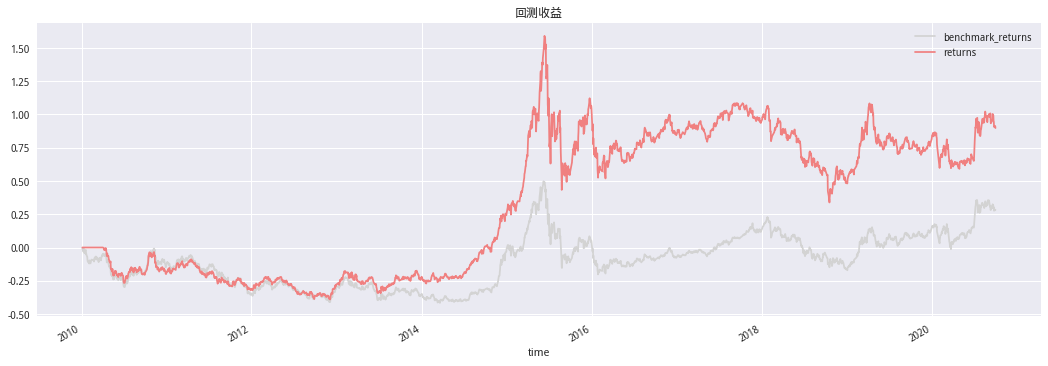

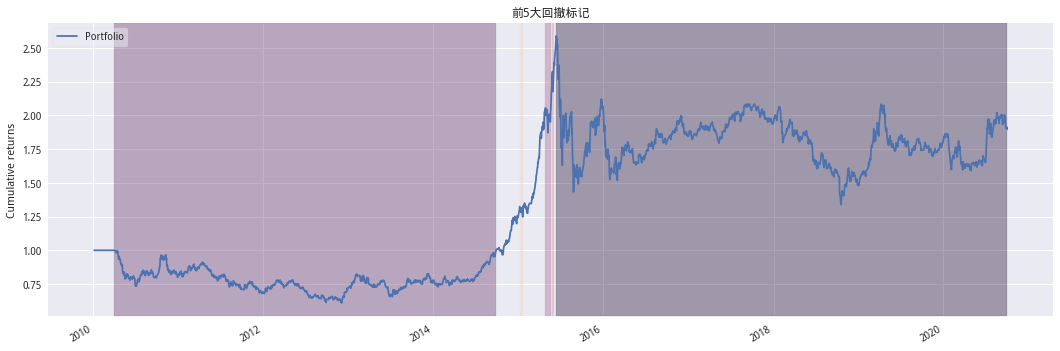

In [190]:
algorithm_show('f1297318ec679d225ae15067fd7d9150')

## PB\PE采用60日均值作为截面数据

PB\PE采用时序数据均值作为截面数据，以期获得改善,但其实改善并不明显

In [170]:
def get_cross_valuation(factors: pd.DataFrame, N: int = 60) -> pd.DataFrame:
    '''
    获取估值截面均值
    ---------------
        factors:pd.DataFram MutliIndex:leve0-date,level1-code
    '''
    df = factors.copy()

    def _calc_mean(df: pd.DataFrame) -> pd.Series:

        trade = df.name

        stocks = df.index.get_level_values(1).tolist()

        valuation_df = get_valuation(stocks, end_date=trade, fields=[
                                     'pb_ratio', 'pe_ratio'], count=N)

        return valuation_df.groupby('code')[['pb_ratio', 'pe_ratio']].mean()
    
    tmp = df.groupby(level='date').apply(_calc_mean)
    
    df[['pb_ratio','pe_ratio']] = tmp[['pb_ratio','pe_ratio']]
    return df

In [174]:
# df3的部分数据已经移动平均处理
df5 = get_cross_valuation(df3)
# 丢弃原有估值数据
df5 = df5.drop(columns=['pb','pe_ttm'])

In [176]:
df5.head()

close       lt_borr     ...      pb_ratio    pe_ratio
date       code                                 ...                          
2010-04-02 000001.XSHE   7.58  2.423623e+10     ...      3.518586   14.316800
           000002.XSHE   7.04  4.375700e+09     ...      2.852350   19.590687
           000005.XSHE   6.07  4.375700e+09     ...      7.379371 -474.004343
           000006.XSHE   3.68  5.275700e+09     ...      2.894243   18.691743
           000009.XSHE   5.34  5.683422e+09     ...      6.445286   52.887329

[5 rows x 10 columns]

In [180]:
# 获取下期收益率
df5 = get_next_ret(df5,True,'2020-10-30')

In [181]:
# 打分 根据逻辑调整升/降序排列
ind_direction = {'pb_ratio': 'descending',
                 'pe_ratio': 'descending',
                 'dv_ttm': 'ascending',
                 'borr2total': 'descending',
                 'c_fcff': 'descending'}

# 打分
df_score2 = score_indicators(df5, ind_direction)

# 分组
group_data2 = add_group(df_score2)

# 收益率
ret2 = pd.pivot_table(group_data2.reset_index(), index='date',
                     columns='group', values='next_ret')
# 净值
nav2 = np.exp(np.log1p(ret2).cumsum())

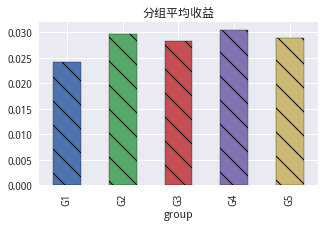

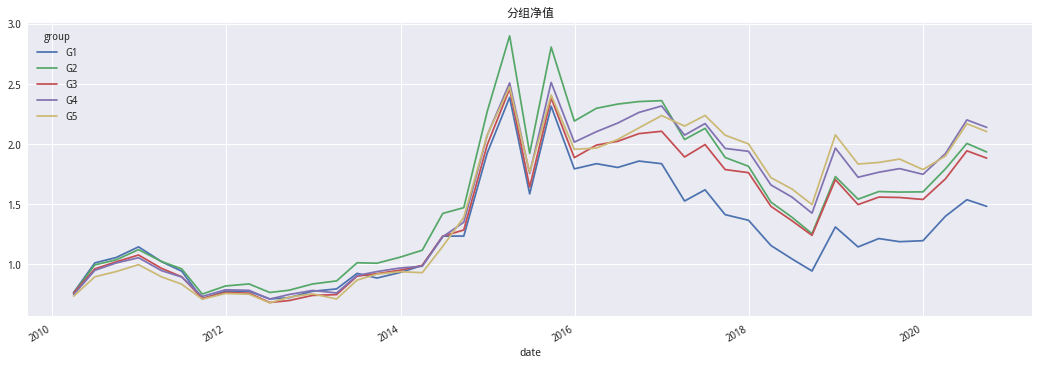

In [183]:
plt.rcParams['font.family'] = 'serif'
ret2.mean().plot.bar(hatch='\\', ec='black', figsize=(5, 3), title='分组平均收益')

nav2.plot(figsize=(18, 6), title='分组净值')

In [189]:
# 获取第5组 得分前30的股票
result_df2 = group_data2.query('group=="G5"').groupby(level='date')[
    'score'].nlargest(30).reset_index(level=0, drop=True)

result_df2 = result_df2.to_frame('score')

# 储存
result_df2.to_csv('../../result_df2.csv')

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,47.99,2015-06-12,2018-10-18,NaT,NaN
1,39.33,2010-04-02,2012-12-03,2014-09-29,1172
2,8.11,2015-04-27,2015-05-07,2015-05-20,18
3,6.57,2015-05-27,2015-05-28,2015-06-02,5
4,5.52,2015-01-27,2015-02-09,2015-02-26,23


,回测情况
algorithm_return,0.913856
algorithm_volatility,0.241878
alpha,0.0390693
annual_algo_return,0.0640486
annual_bm_return,0.0241154
avg_excess_return,0.00017471
avg_position_days,269.714
avg_trade_return,0.053988
benchmark_return,0.282945
benchmark_volatility,0.231394


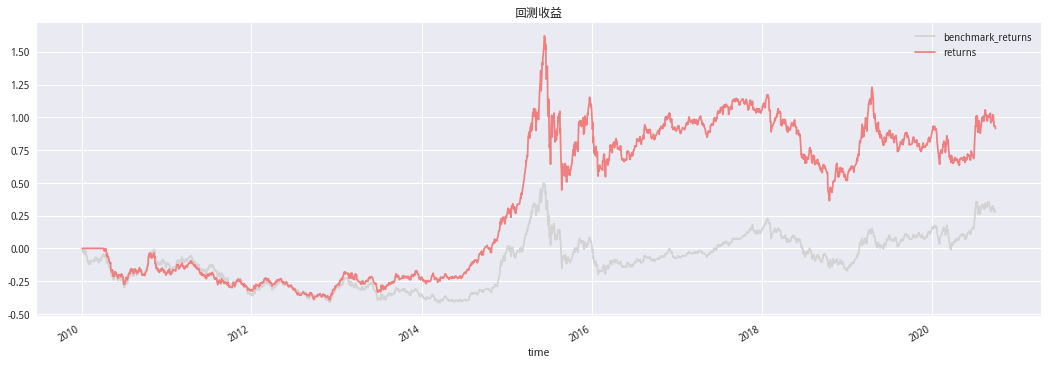

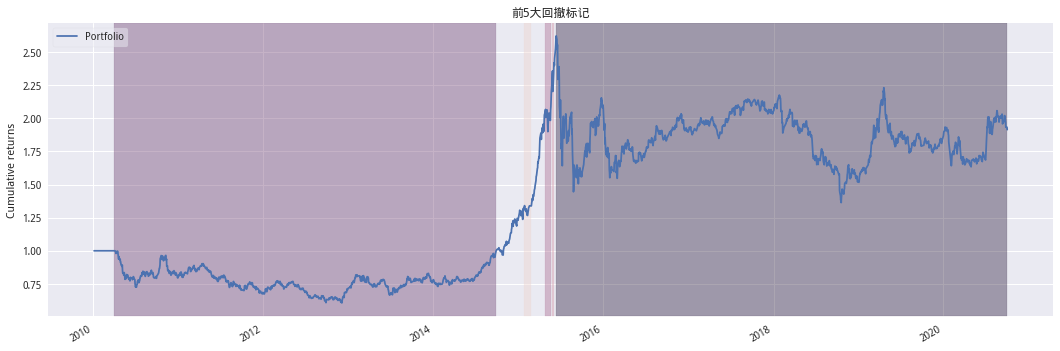

In [191]:
algorithm_show('89551b5e57fbf1c86cec5c91a0470506')